<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW2B/HW2B_problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CONVERGENCE & PRECISION COMPARISON
Converged at epoch 3382 with loss 0.000999948379061352
Epoch  3498, MSE Loss: 0.001000

1. CONVERGENCE RESULTS
----------------------------------------
NumPy Autoencoder:
  - Converged at epoch: 3382
  - Training time: 0.27 seconds
  - Final loss: 0.001000

PyTorch Autoencoder:
  - Converged at epoch: 3498
  - Training time: 2.23 seconds
  - Final loss: 0.001000

2. OUTPUT PRECISION ANALYSIS
----------------------------------------

Reconstruction Accuracy:
  - NumPy:   100.0%
  - PyTorch: 100.0%

NUMPY IMPLEMENTATION
Input     | Hidden Layer Values      | Output Values
----------------------------------------------------------------------------------------------------
10000000 | [ 0.020  0.012  0.874] | [ 0.944  0.000  0.000  0.000  0.000  0.046  0.046  0.029]
01000000 | [ 0.940  0.007  0.120] | [ 0.000  0.944  0.053  0.000  0.001  0.000  0.044  0.032]
00100000 | [ 0.975  0.858  0.006] | [ 0.000  0.027  0.939  0.031  0.054  0.000  0.000  0.000]
00010

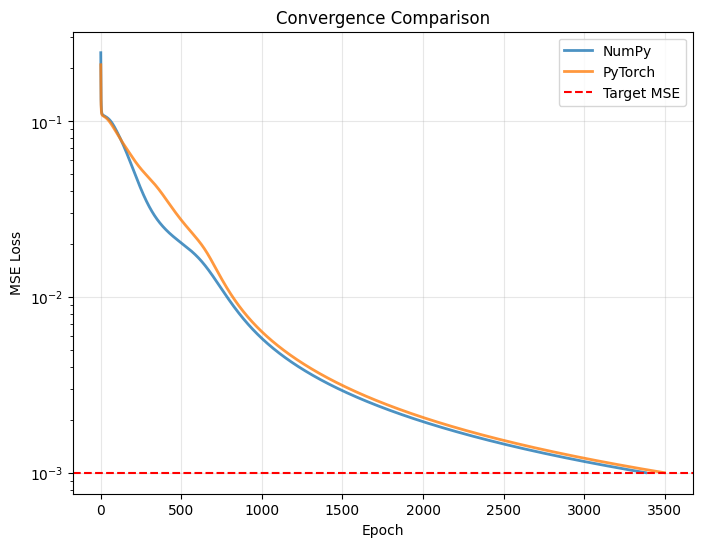

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

class PyTorchAutoEncoder(nn.Module):
    """
    AutoEncoder implementated by PyTorch.
    """
    def __init__(self, learning_rate = 0.5):
        super(PyTorchAutoEncoder, self).__init__()

        self.learning_rate = learning_rate

        # Define Layers
        self.encoder = nn.Sequential(nn.Linear(8, 3), nn.Sigmoid())
        self.decoder = nn.Sequential(nn.Linear(3, 8), nn.Sigmoid())

        # Initialize weights and bias
        with torch.no_grad():
            self.encoder[0].weight.data = torch.randn(3, 8) * 0.5
            self.encoder[0].bias.data.zero_()
            self.decoder[0].weight.data = torch.randn(8, 3) * 0.5
            self.decoder[0].bias.data.zero_()

        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate)

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def get_encoding(self, x):
        with torch.no_grad():
            return self.encoder(x)

    def train_model(self, X, epochs = 1000, target_mse = 0.001):
        """
        Train the autoencoder on the given data.
        """
        X_tensor = torch.FloatTensor(X)

        self.train()

        start_time = time.time()
        self.loss_history = []

        for epoch in range(epochs):
            # Forward Pass
            reconstructed = self(X_tensor)
            loss = self.criterion(reconstructed, X_tensor)

            self.loss_history.append(loss.item())

            if loss.item() < target_mse:
                print(f"Epoch {epoch:5d}, MSE Loss: {loss.item():.6f}")
                self.training_time = time.time() - start_time
                self.convergence_epoch = epoch
                break

            # Backward Pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return self.loss_history

class AutoEncoder:
    """
    AutoEncoder class
    Architecture:
    Input (8) -> Hidden (3) -> Output (3)
    Use sigmoid activation function
    """
    def __init__(self, learning_rate = 0.5):
        self.learning_rate = learning_rate

        # Initialize weights with small random values (nontrivial initialization)
        # First layer: (8, 3)
        self.weights1 = np.random.randn(8, 3) * 0.5
        self.bias1 = np.zeros((1, 3))

        # Second layer: (3, 8)
        self.weights2 = np.random.randn(3, 8) * 0.5
        self.bias2 = np.zeros((1, 8))

        # Store forward pass values
        self.input = None
        self.hidden_input = None
        self.hidden_output = None
        self.final_input = None
        self.final_output = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def forward_pass(self, X):
        """
        Forward pass through the network
        X: input (n, 8) data
        Returns: output (n, 8)
        """
        self.input = X

        # First Layer: Input -> Hidden
        self.hidden_input = self.input @ self.weights1 + self.bias1
        self.hidden_output = self.sigmoid(self.hidden_input)

        # Second Layer: Hidden -> Output
        self.final_input = self.hidden_output @ self.weights2 + self.bias2
        self.final_output = self.sigmoid(self.final_input)

        return self.final_output

    def backward_pass(self, X, y):
        """
        Backward pass through the network
        X: input (n, 8) data
        y: target (n, 8) data
        """
        total_samples = X.size

        # Output Layer
        error = 2 * (self.final_output - y) / total_samples
        d_final_input = error * self.sigmoid_derivative(self.final_output)
        d_weights2 = self.hidden_output.T @ d_final_input
        d_bias2 = np.sum(d_final_input, axis = 0, keepdims = True)

        # Hidden Layer
        d_hidden_output = d_final_input @ self.weights2.T
        d_hidden_input = d_hidden_output * self.sigmoid_derivative(self.hidden_output)
        d_weights1 = self.input.T @ d_hidden_input
        d_bias1 = np.sum(d_hidden_input, axis = 0, keepdims = True)

        return d_weights1, d_bias1, d_weights2, d_bias2

    def update_weights(self, gradient):
        """
        Update weights and biases
        gradients: tuple of (d_weights1, d_bias1, d_weights2, d_bias2)
        """
        d_weights1, d_bias1, d_weights2, d_bias2 = gradient

        self.weights1 -= self.learning_rate * d_weights1
        self.bias1 -= self.learning_rate * d_bias1
        self.weights2 -= self.learning_rate * d_weights2
        self.bias2 -= self.learning_rate * d_bias2

    def train(self, X, epochs = 1000, target_mse = 0.001):
        """
        Train the network
        X: input (n, 8) data
        epochs: number of epochs
        target_mse: target mean squared error
        """
        start_time = time.time()

        loss_history = []

        for epoch in range(epochs):
            # Forward pass
            reconstructed = self.forward_pass(X)

            # Calculate loss
            loss = self.mse_loss(X, reconstructed)
            loss_history.append(loss)

            if loss < target_mse:
                print(f"Converged at epoch {epoch} with loss {loss}")
                self.training_time = time.time() - start_time
                self.convergence_epoch = epoch
                break

            # Backward pass
            gradients = self.backward_pass(X, X)

            # Update weights
            self.update_weights(gradients)

        return loss_history

    def get_encoding(self, X):
        """
        Get the hidden layer representation (encoding) of input X
        """
        _ = self.forward_pass(X)
        return self.hidden_output

def compare_convergence_precision():
    """Compare only convergence and output precision"""

    X = np.eye(8)

    print("="*60)
    print("CONVERGENCE & PRECISION COMPARISON")
    print("="*60)

    # Set hyperparameters
    learning_rate = 15.0
    epochs = 5000
    target_mse = 0.001

    # Train both models
    manual_model = AutoEncoder(learning_rate)
    pytorch_model = PyTorchAutoEncoder(learning_rate)

    manual_losses = manual_model.train(X, epochs, target_mse)
    pytorch_losses = pytorch_model.train_model(X, epochs, target_mse)

    # 1. CONVERGENCE COMPARISON
    print("\n1. CONVERGENCE RESULTS")
    print("-"*40)
    print(f"NumPy Autoencoder:")
    print(f"  - Converged at epoch: {manual_model.convergence_epoch}")
    print(f"  - Training time: {manual_model.training_time:.2f} seconds")
    print(f"  - Final loss: {manual_losses[-1]:.6f}")

    print(f"\nPyTorch Autoencoder:")
    print(f"  - Converged at epoch: {pytorch_model.convergence_epoch}")
    print(f"  - Training time: {pytorch_model.training_time:.2f} seconds")
    print(f"  - Final loss: {pytorch_losses[-1]:.6f}")

    # 2. OUTPUT PRECISION COMPARISON
    print("\n2. OUTPUT PRECISION ANALYSIS")
    print("-"*40)

    # Get final outputs
    manual_output = manual_model.forward_pass(X)
    pytorch_output = pytorch_model(torch.FloatTensor(X)).detach().numpy()

    # Binary accuracy
    manual_binary = (manual_output > 0.5).astype(int)
    manual_encoding = manual_model.get_encoding(X)


    pytorch_model.eval()
    with torch.no_grad():
        pytorch_binary = (pytorch_output > 0.5).astype(int)
        pytorch_encoding = pytorch_model.get_encoding(torch.FloatTensor(X)).detach().numpy()

    manual_accuracy = np.mean(manual_binary == X) * 100
    pytorch_accuracy = np.mean(pytorch_binary == X) * 100

    print(f"\nReconstruction Accuracy:")
    print(f"  - NumPy:   {manual_accuracy:.1f}%")
    print(f"  - PyTorch: {pytorch_accuracy:.1f}%")

    # Show NumPy results
    print("\n" + "="*100)
    print("NUMPY IMPLEMENTATION")
    print("="*100)
    print("Input     | Hidden Layer Values      | Output Values")
    print("-"*100)

    for i in range(8):
        input_pattern = ''.join([str(int(x)) for x in X[i]])
        hidden_str = ' '.join([f"{h:6.3f}" for h in manual_encoding[i]])
        output_str = ' '.join([f"{o:6.3f}" for o in manual_output[i]])
        print(f"{input_pattern} | [{hidden_str}] | [{output_str}]")

    # Show PyTorch results
    print("\n" + "="*100)
    print("PYTORCH IMPLEMENTATION")
    print("="*100)
    print("Input     | Hidden Layer Values      | Output Values")
    print("-"*100)

    for i in range(8):
        input_pattern = ''.join([str(int(x)) for x in X[i]])
        hidden_str = ' '.join([f"{h:6.3f}" for h in pytorch_encoding[i]])
        output_str = ' '.join([f"{o:6.3f}" for o in pytorch_output[i]])
        print(f"{input_pattern} | [{hidden_str}] | [{output_str}]")

    # 3. VISUALIZATION
    fig, ax = plt.subplots(figsize=(8, 6))

    # Convergence plot
    ax.plot(manual_losses, label='NumPy', linewidth=2, alpha=0.8)
    ax.plot(pytorch_losses, label='PyTorch', linewidth=2, alpha=0.8)
    ax.axhline(y=0.001, color='r', linestyle='--', label='Target MSE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_yscale('log')
    ax.set_title('Convergence Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

if __name__ == "__main__":
    compare_convergence_precision()

